# Piyush Verma
## Reg No. : 230968114
## Week2


### Question 1

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt

/Users/ashok/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
#Load the dataset
data = pd.read_csv("Churn_Modelling.csv")
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [4]:
# Drop irrelevant columns
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Geography', 'Gender'], drop_first=True)

In [5]:
# Separate features and target
X = data.drop('Exited', axis=1)
y = data['Exited']

# Scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Split data into train (80%), validation (10%), and test (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)

print(f'Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}, Test samples: {X_test.shape[0]}')

Training samples: 8000, Validation samples: 1000, Test samples: 1000


In [7]:
#build_model
def build_model(hidden_layers, units_per_layer, activation, reg_type=None, reg_value=0.01, learning_rate=0.001):
    model = Sequential()
    input_dim = X_train.shape[1]
    
    # Define regularizer
    regularizer = None
    if reg_type == 'l1':
        regularizer = l1(reg_value)
    elif reg_type == 'l2':
        regularizer = l2(reg_value)

    # Add first hidden layer with input dimension
    model.add(Dense(units_per_layer[0], activation=activation, kernel_regularizer=regularizer, input_dim=input_dim))
    
    # Add subsequent hidden layers if any
    for i in range(1, hidden_layers):
        if units_per_layer[i] > 0:
            model.add(Dense(units_per_layer[i], activation=activation, kernel_regularizer=regularizer))
    
    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Hyperparameter options
hidden_layer_configs = {
    1: [128, 0, 0],
    2: [128, 64, 0],
    3: [128, 64, 32]
}
epochs_list = [10, 20, 30]
activation_functions = ['sigmoid', 'relu']
regularization_options = [None, 'l1', 'l2']
learning_rates = [0.1, 0.01, 0.001]

results = []

for hidden_layers, units_per_layer in hidden_layer_configs.items():
    for epochs in epochs_list:
        for activation in activation_functions:
            for reg in regularization_options:
                for lr in learning_rates:
                    print(f'Training model with {hidden_layers} hidden layers, units {units_per_layer[:hidden_layers]}, '
                          f'epochs={epochs}, activation={activation}, regularization={reg}, learning_rate={lr}')
                    
                    model = build_model(hidden_layers, units_per_layer, activation, reg_type=reg, reg_value=0.001, learning_rate=lr)
                    
                    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=64, verbose=0)
                    
                    # Evaluate on validation data
                    y_val_pred_prob = model.predict(X_val).ravel()
                    y_val_pred = (y_val_pred_prob > 0.5).astype(int)
                    
                    acc = accuracy_score(y_val, y_val_pred)
                    prec = precision_score(y_val, y_val_pred)
                    rec = recall_score(y_val, y_val_pred)
                    
                    results.append({
                        'Hidden_Layers': hidden_layers,
                        'Units': units_per_layer[:hidden_layers],
                        'Epochs': epochs,
                        'Activation': activation,
                        'Regularization': reg,
                        'Learning_Rate': lr,
                        'Accuracy': acc,
                        'Precision': prec,
                        'Recall': rec,
                        'History': history
                    })

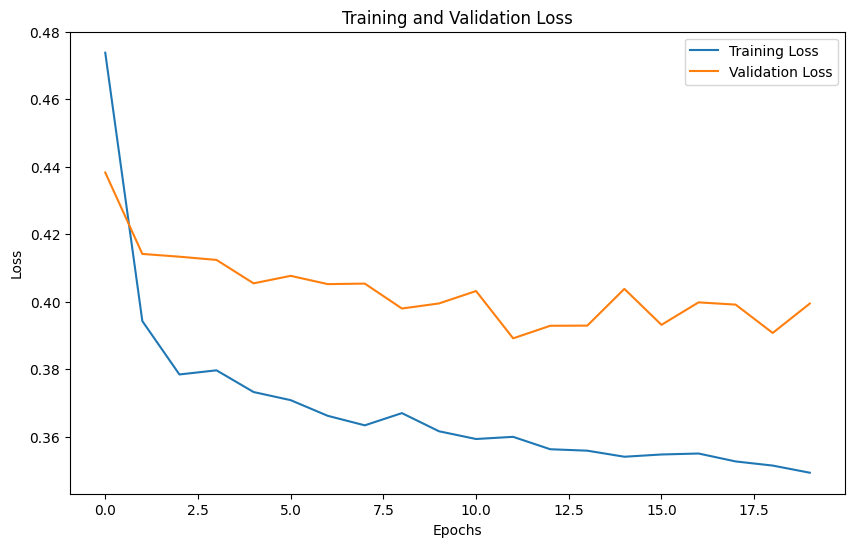

Best hyperparameters:
Hidden_Layers: 1
Units: [128]
Epochs: 20
Activation: relu
Regularization: l1
Learning_Rate: 0.01
Accuracy: 0.848
Precision: 0.7452830188679245
Recall: 0.3872549019607843


In [9]:
# Visualize loss curves for best model by validation accuracy
best_model_info = max(results, key=lambda x: x['Accuracy'])
best_history = best_model_info['History']

plt.figure(figsize=(10,6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Best hyperparameters:")
for k, v in best_model_info.items():
    if k != 'History':
        print(f"{k}: {v}")

# Comments on the best hyperparameters


---

### 1. **Model Architecture:**

- **Hidden Layers:** 1
- **Units:** [128]  
This is a moderately deep network, which balances complexity and overfitting risk. One hidden layers is often sufficient to capture non-linear patterns without making the model too complex or prone to overfitting.

---

### 2. **Epochs: 20**

- Training for 20 epochs is a reasonable choice to allow the model to learn well without overfitting, especially with regularization applied.
- It suggests that the model converged well before 20 epochs or that more epochs didn’t improve performance significantly.

---

### 3. **Activation Function: ReLU**

- ReLU is a standard choice for hidden layers due to its efficiency in training deep networks and ability to reduce vanishing gradient problems.
- This aligns well with current deep learning best practices.

---

### 4. **Regularization: L1**

---

### 5. **Learning Rate: 0.01**

- A small learning rate allows the optimizer to make careful, incremental improvements.
- This is typical and generally results in more stable and better convergence compared to larger learning rates.

---

### 6. **Performance Metrics:**

| Metric    | Value | Comment                                                                                  |
|----------|-------|------------------------------------------------------------------------------------------|
| Accuracy | 0.848 | Strong overall correctness—model predicts 85% cases correctly. Good for imbalanced classes too. |
| Precision| 0.745 | About 75% of predicted churners actually churn, indicating decent confidence in positive predictions. |
| Recall   | 0.387 | Recall is relatively low, meaning the model misses more than half of the actual churners. This suggests a trade-off—model is conservative in flagging churners. |

---


In [10]:
# Rebuild the best model to evaluate on test set
best = best_model_info
model = build_model(best['Hidden_Layers'], list(best['Units']) + [0]*(3-best['Hidden_Layers']),
                    best['Activation'], reg_type=best['Regularization'], reg_value=0.001, learning_rate=best['Learning_Rate'])

model.fit(X_train, y_train, epochs=best['Epochs'], batch_size=64, verbose=0)

y_test_pred_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")

/Users/ashok/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
Test Accuracy: 0.8540, Precision: 0.7339, Recall: 0.4461


# Question 2 (Body Fat Dataset)

In [11]:
#Load the dataset
df = pd.read_csv('bodyfat.csv')
df

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,11.0,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,1.0236,33.6,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,1.0328,29.3,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,1.0399,26.0,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


In [12]:
# Features (exclude Density and BodyFat from inputs, since Density requires underwater weighing)
X = df.drop(['Density', 'BodyFat'], axis=1)  # use easier to measure features only
y = df['BodyFat']

In [13]:
#Split data into train and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Split train+val into 80% train, 10% val 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42)

print(f'Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}, Test samples: {X_test.shape[0]}')

Train samples: 200, Validation samples: 26, Test samples: 26


In [14]:
#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Build model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # regression output (body fat %)

# Compile model with Adam optimizer and learning rate = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])  # MSE loss and MAE metric

model.summary()

/Users/ashok/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_488 (Dense)               │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_489 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_490 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_491 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#Train model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,   # you can adjust epochs as needed
    batch_size=32,
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 707.4785 - mae: 21.2491 - val_loss: 431.5768 - val_mae: 18.1311
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 341.7849 - mae: 16.0864 - val_loss: 332.5517 - val_mae: 15.6783
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 218.4619 - mae: 12.4749 - val_loss: 308.6858 - val_mae: 15.0950
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 267.2288 - mae: 14.3558 - val_loss: 237.4702 - val_mae: 13.6165
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 146.3228 - mae: 10.1347 - val_loss: 183.0612 - val_mae: 10.0576
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 132.4056 - mae: 9.7446 - val_loss: 163.8236 - val_mae: 10.6431
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.9945 - mae: 8.4400 - val_loss: 123.8674 - val_mae: 9.0168
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 98.4582 - mae: 7.8119 - val_loss: 88.7925 - val_mae: 7.6155
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

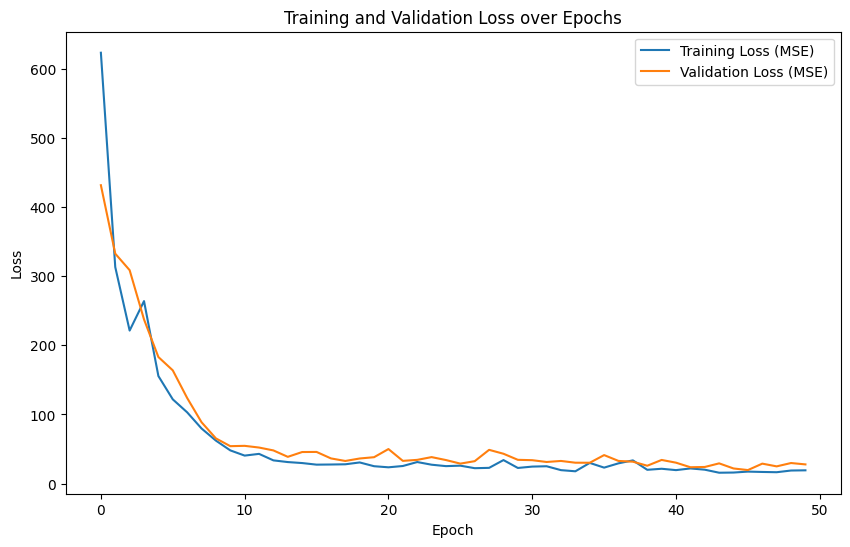

In [17]:
#Plot Loss over Epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [18]:
#Evaluate on Test Data
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f'Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 14.9552 - mae: 3.2573
Test MSE: 14.9552, Test MAE: 3.2573
